In [1]:
import json
import os
import random
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from alive_progress import alive_bar
from sentence_transformers import SentenceTransformer, util

from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# import data

In [2]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# helper functions

In [3]:
# DATA CLEANING FUNCTIONS

def clean_text(text, skip_cleaning=False):
    if not skip_cleaning:
        allowed_chars = r"[^a-zA-ZÀ-ÖØ-öø-ÿ0-9.,;:!?()'\"-]"
        text = re.sub(allowed_chars, ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

    return text


def get_files_for_publication(pub_number, fr_eng_correlation_df):
    row = fr_eng_correlation_df.loc[fr_eng_correlation_df['pub_number'] == pub_number]
    if not row.empty:
        filename_fr = row['filename_fr'].values[0]
        filename_en = row['filename_en'].values[0]
        return filename_fr, filename_en
    return None, None


def get_json_file_link(parsed_docs_folder, pdf_filename):
    if pdf_filename.endswith(".pdf"):
        json_filename = pdf_filename + ".json"
        for root, _, files in os.walk(parsed_docs_folder):
            if json_filename in files:
                return os.path.join(root, json_filename)
    return None


def extract_text_from_single_file(json_file, target_language, clf, skip_cleaning=False):
    min_block_length = 10
    max_block_length = 500
    
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = clean_text(data['text'], skip_cleaning)
    text_blocks = re.split(r'(?<![;,])[.?!]\s|\n\n', full_text)
    text = []

    for block in text_blocks:
        block = block.strip()
        if len(block) < min_block_length or len(block) > max_block_length:
            continue
        
        if clf.classify(block) == target_language:
            text.append(block + '. ')      

    return " ".join(text)


def extract_both_languages_from_two_files(json_file_fr, json_file_en, clf, skip_cleaning=False):
    return extract_text_from_single_file(json_file_fr, "fr", clf, skip_cleaning), extract_text_from_single_file(json_file_en, "en", clf, skip_cleaning)


def extract_both_languages_from_single_file(json_file, clf, skip_cleaning=False):
    min_block_length = 10
    max_block_length = 500
    
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = clean_text(data['text'], skip_cleaning)
    text_blocks = re.split(r'(?<![;,])[.?!]\s|\n\n', full_text)
    text_fr, text_en = [], []

    for block in text_blocks:
        block = block.strip()
        if len(block) < min_block_length or len(block) > max_block_length:
            continue
            
        if clf.classify(block) == "fr":
            text_fr.append(block + '. ')   
        elif clf.classify(block) == "en":
            text_en.append(block + '. ')   

    return " ".join(text_fr), " ".join(text_en)


def create_sentences(text_fr, text_en):
    sentences_fr = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_fr) if x != ""]
    sentences_en = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_en) if x != ""]
    
    return sentences_fr, sentences_en


def create_similarity_matrix(sentences_fr, sentences_en, sentence_encoder):
    embeddings_fr = sentence_encoder.encode(sentences_fr, convert_to_tensor=True)
    embeddings_en = sentence_encoder.encode(sentences_en, convert_to_tensor=True)

    return util.pytorch_cos_sim(embeddings_fr, embeddings_en)


# TODO: process_all_rows replaced with debug version (below) for this analysis


def text_from_coordinates(aligned_pairs, sentences_fr, sentences_en, pub_number):
    correlated_list = list()
    for i, j in aligned_pairs:
        correlated_list.append((pub_number, sentences_fr[i], sentences_en[j]))
    
    return correlated_list


def correlate_and_clean_text(text_fr, text_en, pub_number, sentence_encoder):
    sentences_fr, sentences_en = create_sentences(text_fr, text_en)
    similarity_matrix = create_similarity_matrix(sentences_fr, sentences_en, sentence_encoder)
    _, _, aligned_pairs = align_sentences(similarity_matrix)  # TODO: updated for EDA

    return text_from_coordinates(aligned_pairs, sentences_fr, sentences_en, pub_number)


# TODO: process_all_rows replaced with debug version (below) for this analysis


# PREVIEW AND DEBUGGING

def preview_publication(pub_number):
    if type(pub_number) is pd.DataFrame and pub_number.shape[0] == 1:
        try:
            pub_number = pub_number['pub_number'].values[0]
        except ValueError:
            return None
    elif type(pub_number) is pd.Series:
        try:
            pub_number = pub_number.values[0]
        except ValueError:
            return None
    
    try:
        output_df = weblinks_df[weblinks_df.pub_number == pub_number].T
    except Exception as e:
        print(e)
        return None
        
    display(output_df)


def preview_publication_by_row(row_n):
    display(pd.DataFrame(matched_df.iloc[row_n]))
    preview_publication(matched_df.iloc[row_n].pub_number)
    
    
def plot_similarity_heatmap(similarity_matrix, figsize=(10, 10), low_similarity=0.6, high_similarity=0.8, matched_pairs=None, cmap=None, norm=None, square=True):
    fig, ax = plt.subplots(figsize=figsize) 
    
    if cmap:
        if norm:
            sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, square=square, linewidths=0, ax=ax)
        else:
            sns.heatmap(similarity_matrix, cmap=cmap, cbar=False, square=square, linewidths=0, ax=ax)
    else:
        cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
        bounds = [0, low_similarity, high_similarity, 1]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
        sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, square=square, linewidths=0, ax=ax)

    if matched_pairs:
        x_coords, y_coords = zip(*matched_pairs)
        ax.plot(x_coords, y_coords, marker='o', linestyle='-', color='red', markersize=4, linewidth=1.5)

    ax.tick_params(left=False, bottom=False)

    plt.tight_layout()
    plt.show()
    

def display_similarity_matrix(similarity_matrix, inverse=False, figsize=(10, 10)):
    if inverse:
        plot_similarity_heatmap(similarity_matrix.T, figsize=figsize)
    else:
        plot_similarity_heatmap(similarity_matrix, figsize=figsize)


def text_from_row(row_n):
    return matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en']


def text_from_pub_number(pub_number):
    return matched_df[matched_df.pub_number == pub_number].text_fr.values[0], matched_df[matched_df.pub_number == pub_number].text_en.values[0]



# TODO: ALTERNATE VERSION OF ALIGN SENTENCE FOR EDA
def align_sentences(sim_matrix, threshold=0.7):
    n, m = sim_matrix.shape

    weights = np.where(sim_matrix >= threshold, sim_matrix, 0.0)

    dp = np.zeros((n+1, m+1), dtype=np.float32)

    for i in range(1, n+1):
        for j in range(1, m+1):
            score_match = dp[i-1, j-1] + weights[i-1, j-1]
            score_skip_fr = dp[i-1, j]
            score_skip_en = dp[i, j-1]

            dp[i, j] = max(score_match, score_skip_fr, score_skip_en)

    aligned_pairs = []
    i, j = n, m
    while i > 0 and j > 0:
        current_val = dp[i, j]
        if np.isclose(current_val, dp[i-1, j]):
            i -= 1
        elif np.isclose(current_val, dp[i, j-1]):
            j -= 1
        else:
            if weights[i-1, j-1] > 0:
                aligned_pairs.append((i-1, j-1))
            i -= 1
            j -= 1

    aligned_pairs.reverse()
    return dp, dp[n, m], aligned_pairs


# TODO: ALTERNATE VERSION OF PROCESS ALL ROWS FOR EDA
def process_all_rows_debug(fr_eng_correlation_df, parsed_docs_folder, clf):
    matched_data = []

    for _, row in fr_eng_correlation_df.iterrows():
        pub_number = row['pub_number']
        filename_fr, filename_en = row['filename_fr'], row['filename_en']

        if filename_fr == "WITHDRAWN" and filename_en == "WITHDRAWN":
            continue

        fr_link = get_json_file_link(parsed_docs_folder, filename_fr)
        if fr_link == None:
            continue

        if filename_fr == filename_en:
            text_fr, text_en = extract_both_languages_from_single_file(fr_link, clf, True)  # TODO: confirm skipping cleaning until final step
        else:
            en_link = get_json_file_link(parsed_docs_folder, filename_en) 
            if en_link == None:
                continue
            text_fr, text_en = extract_both_languages_from_two_files(fr_link, en_link, clf, True)  # TODO: confirm skipping cleaning until final step

        matched_data.append({'pub_number': pub_number, 'text_fr': text_fr, 'text_en': text_en})

    return pd.DataFrame(matched_data)

# Website Errors

In [4]:
max_ratio = 2  # low quality / only abstract data to exclude (<7% of total translated data)
min_char = 1000  # low quality, bad OCR, or incomplete transcription / parsing

In [5]:
junk_df = matched_df.loc[(matched_df.len_fr < min_char) | (matched_df.len_en < min_char) | (matched_df.len_diff > max_ratio)].copy()
junk_pub_numbers = junk_df['pub_number'].to_list() 
junk_df.loc[:, 'year'] = junk_df['pub_number'].str.extract(r'(\d{4})')
junk_df['year'] = pd.to_numeric(junk_df['year'], errors='coerce')

good_df = fr_eng_correlation_df[(~fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)) & (fr_eng_correlation_df.filename_fr != "WITHDRAWN")].copy()
good_df.loc[:, 'year'] = good_df['pub_number'].str.extract(r'(\d{4})')
good_df['year'] = pd.to_numeric(good_df['year'], errors='coerce')

# # CONFIRMED: only fr abstract, all else en 
# preview_publication_by_row(5412)
# preview_publication_by_row(5607)
# preview_publication_by_row(4605)
# preview_publication_by_row(3580)
# preview_publication_by_row(5457)
# preview_publication_by_row(4768)

all_years = np.arange(1977, 2025)
junk_year_counts = junk_df['year'].value_counts().reindex(all_years, fill_value=0)
good_year_counts = good_df['year'].value_counts().reindex(all_years, fill_value=0)

plt.figure(figsize=(16, 8))
plt.bar(junk_year_counts.index, junk_year_counts.values, color='blue', edgecolor='black', label='Junk Data', hatch='xxxx')
plt.bar(good_year_counts.index, good_year_counts.values, color='blue', edgecolor='black', label='Good Data', bottom=junk_year_counts.values)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of Publications Per Year (1977-2024)")
plt.legend()

plt.show()

NameError: name 'matched_df' is not defined

### duplicated pub_number

In [60]:
duplicated_pub_numbers = fr_eng_correlation_df['pub_number'].value_counts()[fr_eng_correlation_df['pub_number'].value_counts() > 1].index.to_list()

# SCR 2020/018 and PRO 2024/041 are fine, SSR 2002/D2-01 is broken
fr_eng_correlation_df[fr_eng_correlation_df.pub_number.isin(duplicated_pub_numbers)]

,pub_number,filename_fr,filename_en
1283,PRO 2024/041,41265841.pdf,4126583x.pdf
1284,PRO 2024/041,41265841.pdf,4126583x.pdf
8105,SCR 2020/018,40878090.pdf,40884545.pdf
8106,SCR 2020/018,40878090.pdf,40884545.pdf
8933,SSR 2002/D2-01,345791.pdf,317513.pdf
8955,SSR 2002/D2-01,345792.pdf,317694.pdf


In [61]:
# broken pub_number 
#   it looks like these are actually "correct" 
#   there are 2 identical pub numbers, for the Apr and Nov 2002 SSR (both languages)
preview_publication("SSR 2002/D2-01")

,8933,8955
pub_number,SSR 2002/D2-01,SSR 2002/D2-01
nom,État des stocks de saumon atlantique de Terre-Neuve et du Labrador en 2001.,Mise à jour de l'état des stocks de saumon atlantique de Terre-Neuve et du Labrador en 2002.
name,Newfoundland & Labrador Atlantic Salmon Stock Status for 2001,Newfoundland & Labrador Atlantic Salmon 2002 StockStatus Update.
url_fr,http://waves-vagues.dfo-mpo.gc.ca/Library/345791.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/345792.pdf
url_en,http://waves-vagues.dfo-mpo.gc.ca/Library/317513.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/317694.pdf
file_url_fr,http://waves-vagues.dfo-mpo.gc.ca/Library/345791.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/345792.pdf
file_url_en,http://waves-vagues.dfo-mpo.gc.ca/Library/317513.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/317694.pdf


### Only Abstract Translated

In [62]:
abstract_only = matched_df[(matched_df.len_diff > max_ratio) & (matched_df.filename_fr == matched_df.filename_en)].copy()

abstract_only.sample(10).drop(['text_fr', 'text_en'], axis=1)

,pub_number,len_fr,len_en,len_diff,len_min,filename_fr,filename_en
4799,RES 2010/070,1898,114250,60.2,1898,341257.pdf,341257.pdf
500,PRO 2009/023,3503,76088,21.7,3503,337754.pdf,337754.pdf
2461,RES 1991/081,1375,20569,15.0,1375,134438.pdf,134438.pdf
3384,RES 1999/038,2107,28716,13.6,2107,242106.pdf,242106.pdf
2379,RES 1990/092,2164,18266,8.4,2164,123763.pdf,123763.pdf
2508,RES 1992/045,1268,57749,45.5,1268,137679.pdf,137679.pdf
1966,RES 1986/060,1396,11399,8.2,1396,92661.pdf,92661.pdf
3286,RES 1998/101,3203,50418,15.7,3203,228355.pdf,228355.pdf
406,PRO 2007/022,2348,27071,11.5,2348,329179.pdf,329179.pdf
3915,RES 2002/031,2526,24890,9.9,2526,266053.pdf,266053.pdf


### likley bad references on website

In [63]:
bad_weblinks = matched_df[(matched_df.len_diff > max_ratio) & (matched_df.filename_fr != matched_df.filename_en)].copy()

for pub_number in bad_weblinks.pub_number.to_list():
    preview_publication(pub_number)

,737
pub_number,PRO 2012/059
nom,"Compte rendu de l'évaluation nationale des risques posés par la moule zébrée, la moule quagga et..."
name,"Proceedings of the National Risk Assessment of Zebra Mussel, Quagga Mussel and Dark Falsemussel;..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_059-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_059-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348617.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348616.pdf


,3642
pub_number,RES 2000/041
nom,NaN
name,"Status of Atlantic salmon (Salmo salar L.) In Indian bay Brook, Middle Brook, and Terra Nova Riv..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/265909.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/248180.pdf


,5275
pub_number,RES 2013/002
nom,Mise à jour de l'estimation de biomasse et d'abondance de la crevette nordique (Pandalus boreali...
name,Update of the estimation of northern shrimp (Pandalus borealis) biomass and abundance from the t...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_002-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_002-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348703.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348701.pdf


,6017
pub_number,RES 2020/066
nom,Abondance de la population et caractéristiques biologiques du Dolly Varden (Salvelinus malma mal...
name,Population abundance and biological characteristics of Dolly Varden (Salvelinus malma malma) fro...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2020/2020_066-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2020/2020_066-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40953348.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40953324.pdf


,6212
pub_number,RES 2023/026
nom,"Examen pré-COSEPAC du saumon atlantique (Salmo salar) anadrome Canada, partie 1 : Unités désigna..."
name,"Pre-COSEWIC Review of Anadromous Atlantic Salmon (Salmo salar) in Canada, Part 1: Designatable U..."
url_fr,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2023/2023_026-fra.html
url_en,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2023/2023_026-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41117748.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41117554.pdf


,6767
pub_number,SAR 2010/070
nom,Directives pour l'utilisation de méthodes mises à jour pour l'évaluation des règles de pêche au ...
name,Guidelines for applying updated methods for assessing harvest rules for Fraser River sockeye sal...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2010/2010_070-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2010/2010_070-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/343603.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/343602.pdf


,6843
pub_number,SAR 2011/067
nom,"Avis scientifique découlant de l'évaluation du risque d'introduction, par les navires, d'espèces..."
name,Science advice from the risk assessment for ship-mediated introductions of aquatic nonindigenous...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2011/2011_067-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2011/2011_067-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/346314.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/346313.pdf


,6922
pub_number,SAR 2012/045
nom,"Évaluation de l'inconnu (Stenodus leucichthys) de la rivière Buffalo, Grand lac des Esclaves, Te..."
name,"Assessment of Buffalo River Inconnu (Stenodus leucichthys) Great Slave Lake, Northwest Territori..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348373.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348324.pdf


,7062
pub_number,SAR 2014/042
nom,Évaluation du stock de goberge dans la sous-division 3Ps
name,Stock Assessment on Subdivision 3Ps Pollock
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2014/2014_042-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2014/2014_042-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/352153.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/364309.pdf


,7761
pub_number,SCR 2012/041
nom,Probabilité que les stocks de crevette tachetée (Pandalus platyceros) se trouvant dans les zones...
name,Probability of spot prawn (Pandalus platyceros) stocks in fall survey areas in British Columbia ...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347658.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347657.pdf


,7839
pub_number,SCR 2014/033
nom,Évaluation de la possibilité de rouvrir les zones de fermeture A et B du Grand Lac des esclaves
name,Assessment of the potential to re-open Great Slave Lake Closure Zones A and B
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/scr-rs/2014/2014_033-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2014/2014_033-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363608.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363607.pdf


,8538
pub_number,SSR 1997/G3-02
nom,"État du phytoplancton, du zooplancton et du krill sur le plateau néo-écossais en 1996"
name,"State of phytoplankton, zooplankton and krill on the Scotian Shelf in 1996"
url_fr,http://waves-vagues.dfo-mpo.gc.ca/Library/219497.pdf
url_en,http://waves-vagues.dfo-mpo.gc.ca/Library/219073.pdf
file_url_fr,http://waves-vagues.dfo-mpo.gc.ca/Library/219497.pdf
file_url_en,http://waves-vagues.dfo-mpo.gc.ca/Library/219073.pdf


# check corpus to make sure it's reasonable (doesn't look great)

In [64]:
# also check matched_df pub_number counts for minimal entries (ie, very few strong matches)
corpus_df = pd.read_pickle("matched_data_without_text_cleaning.pickle")

corpus_df = pd.merge(
    corpus_df,
    matched_df.drop_duplicates('pub_number', keep="first"),
    on="pub_number",
    how="left"
)

FileNotFoundError: [Errno 2] No such file or directory: 'matched_data.pickle'

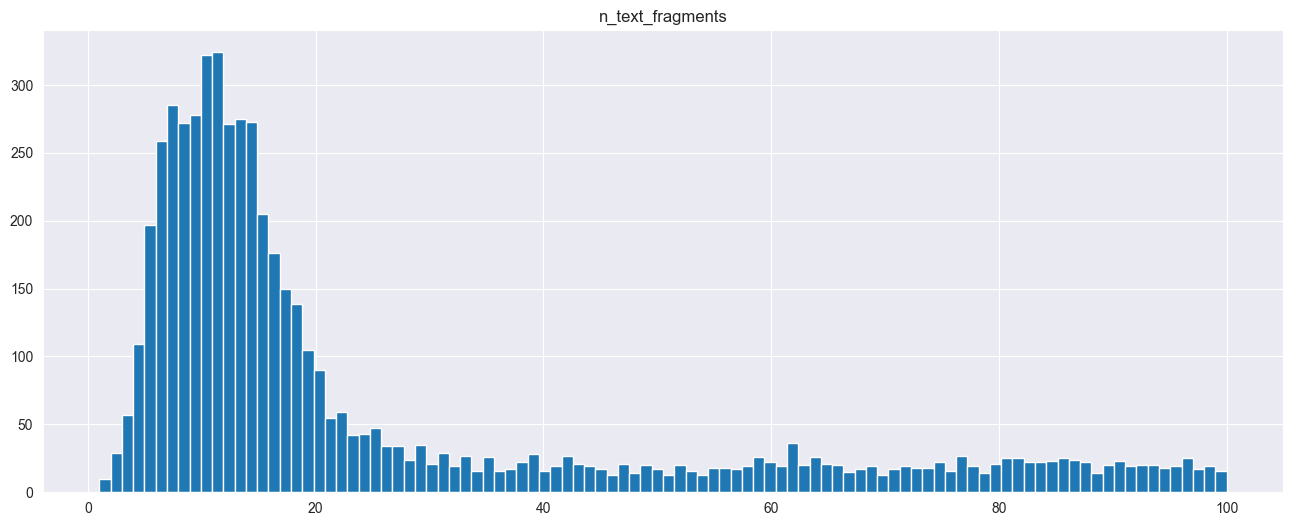

In [159]:
corpus_value_counts = pd.DataFrame(corpus_df.pub_number.value_counts())
corpus_value_counts.columns = ['n_text_fragments']
corpus_value_counts[corpus_value_counts.n_text_fragments <= 100].hist(bins=100, figsize=(16, 6));

In [160]:
pub_numbers_with_bad_translations = corpus_value_counts[corpus_value_counts.n_text_fragments < 20].index.to_list()

len(pub_numbers_with_bad_translations)

3736

In [161]:
random.sample(pub_numbers_with_bad_translations, 10)

['RES 1991/026',
 'RES 1997/131',
 'RES 2000/156',
 'RES 2001/079',
 'RES 1980/070',
 'RES 1999/153',
 'RES 2004/025',
 'RES 1986/081',
 'PRO 2003/010',
 'RES 2013/058']

In [142]:
preview_publication('RES 1997/060')
preview_publication('RES 1995/075')
preview_publication('RES 1997/046')
preview_publication('RES 2012/037')
preview_publication('PRO 2015/065')
preview_publication('RES 1987/035')
preview_publication('RES 1988/071')
preview_publication('RES 2002/022')
preview_publication('RES 1999/129')
preview_publication('RES 1985/101')

,3131
pub_number,RES 1997/060
nom,NaN
name,Trends in abundance of short-finned squid (Illex illecebrosus) and environmental conditions in the northwest Atlantic.
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1997/1997_060-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1997/1997_060-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/212620.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/212620.pdf


,2864
pub_number,RES 1995/075
nom,NaN
name,Analysis of replacement in eight northwest Atlantic cod stocks (11 p.)
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1995/1995_075-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1995/1995_075-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/184322.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/184322.pdf


,3117
pub_number,RES 1997/046
nom,NaN
name,"Results of 1996 research surveys of sea scallop abundance in areas near Grand Manan Island and Cape Spencer, Bay of Fundy."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1997/1997_046-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1997/1997_046-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/228361.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/228361.pdf


,5124
pub_number,RES 2012/037
nom,"Résultats des relevés aériens du narval (Monodon monoceros) dans le nord de la baie d'Hudson, août 2011"
name,"Results of narwhal (Monodon monoceros) aerial surveys in northern Hudson Bay, August 2011"
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2012/2012_037-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2012/2012_037-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347183.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347183.pdf


,896
pub_number,PRO 2015/065
nom,"Compte rendu de l'examen par les pairs de la région du Pacifique sur l' Évaluation des stocks de sébaste à longue mâchoire dans les zones 3CD et 5DE (Colombie-Britannique); et Évaluation simultanée des stocks de cinq sébastes des eaux de la Colombie-Britannique : bec-de-lièvre, à bandes vertes, à raie rouge, arlequin et à menton pointu ; Le 6 au 9 novembre 2012"
name,"Proceedings of the Pacific regional peer review on Stock assessment for Pacific Ocean Perch in Areas 3CD and 5DE (British Columbia); and A Simultaneous Stock Assessment of Five Rockfishes in British Columbia Waters: Splitnose, Greenstriped, Redstripe, Harlequin and Sharpchin Rockfish; November 6-9, 2012"
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/pro-cr/2015/2015_065-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/pro-cr/2015/2015_065-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/362437.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/362437.pdf


,2087
pub_number,RES 1987/035
nom,NaN
name,Redfish (Sebastes spp.) in Management Unit 4VWX: An assessment of present stock status
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1987/1987_035-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1987/1987_035-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/102280.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/102280.pdf


,2230
pub_number,RES 1988/071
nom,NaN
name,Assessment of Divisions 4VWX and Subarea 5 pollock (Pollachius virens)
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1988/1988_071-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1988/1988_071-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/110800.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/110800.pdf


,3959
pub_number,RES 2002/022
nom,Effort de pêche du homard sur le littoral extérieur de la Nouvelle-Écosse en 1983 par opposition à 1998
name,Lobster Fishing Effort on the Outer Coast of Nova Scotia 1983 versus 1998
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_022-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_022-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/264717.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/264717.pdf


,3513
pub_number,RES 1999/129
nom,NaN
name,Run size forecasts for Fraser River sockey and pink salmon in 1999.
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1999/1999_129-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1999/1999_129-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/238466.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/238466.pdf


,1925
pub_number,RES 1985/101
nom,NaN
name,Assessment of the Nepisiguit River salmon stock in 1984
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1985/1985_101-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1985/1985_101-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/89403.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/89403.pdf


In [172]:
(
    corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr == corpus_df.filename_en)].shape[0], 
    corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr != corpus_df.filename_en)].shape[0]
 )

(39732, 526)

In [183]:
# total pub numbers in corpus, # bad translations, # bad translations with different files
(
    corpus_df.pub_number.nunique(), 
    corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr == corpus_df.filename_en)].pub_number.nunique(),
    corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr != corpus_df.filename_en)].pub_number.nunique()
)
# all, abstract only, messed up?

(8020, 3697, 39)

In [186]:
pub_numbers_abstract_only = corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr == corpus_df.filename_en)].pub_number.to_list()
pub_numbers_messed_up = corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr != corpus_df.filename_en)].pub_number.to_list()

In [192]:
random_pub_number = random.choice(pub_numbers_abstract_only)

print(random_pub_number)
preview_publication(random_pub_number)
corpus_df[corpus_df.pub_number == random_pub_number][['fr', 'en']]

RES 2011/097


,5049
pub_number,RES 2011/097
nom,"Évaluation de la situation du bar rayé (Morone saxatilis) dans le sud du golfe du Saint-Laurent, 2006 à 2010"
name,"Assessment and status of Striped Bass (Morone saxatilis) in the Southern Gulf of St. Lawrence, 2006 to 2010"
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2011/2011_097-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2011/2011_097-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/344946.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/344946.pdf


,fr,en
231797,Secrétariat canadien de consultation scientifique,Canadian Science Advisory Secretariat
231798,La présente série documente les fondements \nscientifiques des évaluations des ressources et \ndes écosystèmes aquatiques du Canada,This series documents the scientific basis for the \nevaluation of aquatic resources and ecosystems \nin Canada
231799,"Les documents qu’elle \ncontient ne doivent pas être considérés comme \ndes énoncés définitifs sur les sujets traités, mais \nplutôt comme des rapports d’étape sur les \nétudes en cours","As such, it addresses the issues of \nthe day in the time frames required and the \ndocuments it contains are not intended as \ndefinitive statements on the subjects addressed \nbut rather as progress reports on ongoing \ninvestigations"
231800,Les documents de recherche sont publiés dans \nla langue officielle utilisée dans le manuscrit \nenvoyé au Secrétariat,Research documents are produced in the official \nlanguage in which they are provided to the \nSecretariat
231801,Ce document est disponible sur l’Internet à:,This document is available on the Internet at:
231802,"Évaluation de la situation du bar rayé \n(Morone saxatilis) dans le sud du golfe \ndu Saint-Laurent, 2006 à 2010",ABSTRACT \n \nThe status of the Striped Bass (Morone saxatilis) stock in the southern Gulf of St
231803,Les \nestimés d’abondance de géniteurs se situent en moyenne à 50 000 (16 200 à 92 160 écart \nannuel) poissons durant les cinq dernières années (2006 à 2010) et à 35 000 (12 550 à 92 160 \nécart annuel) poissons durant la dernière décennie (2001 à 2010),"Estimates of spawner \nabundance have averaged 50,000 (16,200 to 92,160 annual range) over the last 5 years (2006 \nto 2010) and 35,000 (12,550 to 92,160) over the last decade (2001 to 2010)"
231804,"L’estimé de mortalité totale pour \nles bar rayé adultes de cette population demeure élevé (0,47) mais on croit que le niveau de \nmortalité naturelle sur ces poissons est bas",The estimate of total mortality for adult Striped Bass continues to be high (0.47) for \nthis population and natural mortality is believed to be low
231805,L’objectif limite (21 600 géniteurs dans au moins 5 \ndes 6 dernières années) et l’objectif cible (31 200 géniteurs dans 3 des 6 années) de \nrétablissement proposés pour la population de bar rayé pour le sud du golfe pourraient être \natteints pour la première fois en 2011,"The proposed recovery limit (21,600 \nspawners in 5 of the last 6 years) and target (31,200 spawners in 3 of 6 years) for southern Gulf \nStriped Bass could be met for the first time in 2011"


In [194]:
# RES 2011/097: why didn't this get excluded? len_diff = 17???

matched_df[matched_df.pub_number == 'RES 2011/097'].T

4977
pub_number                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [215]:
row = fr_eng_correlation_df[fr_eng_correlation_df.pub_number == 'RES 2011/097']
pub_number = 'RES 2011/097'

filename_fr, filename_en = row['filename_fr'].values[0], row['filename_en'].values[0]

if filename_fr == "WITHDRAWN" and filename_en == "WITHDRAWN":
    print('continue')

fr_link = get_json_file_link(parsed_docs_folder, filename_fr)
if fr_link == None:
    print('continue')

if filename_fr == filename_en:
    text_fr, text_en = extract_both_languages_from_single_file(fr_link, language_classifier)
else:
    en_link = get_json_file_link(parsed_docs_folder, filename_en) 
    if en_link == None:
        print('continue')
    text_fr, text_en = extract_both_languages_from_two_files(fr_link, en_link, language_classifier)

# low-quality text criteria
len_fr, len_en = len(text_fr), len(text_en)
if len_fr == 0 or len_en == 0:
    print('continue')
elif 1 / max_ratio > len(text_fr) / len(text_en) > max_ratio:
    print('continue')
elif len(text_fr) < min_char or len(text_en) < min_char:
    print('continue')

temp_list_of_correlated_text = correlate_and_clean_text(text_fr, text_en, pub_number, sentence_encoder)

In [219]:
# the data is fine, but why did the second last continue never trigger? 
# -> messed up inequality, none excluded for len ratio

for x, y, z in temp_list_of_correlated_text:
    print(x)
    print('\t', y)
    print('\t\t', z)
    print()

RES 2011/097
	 Secrétariat canadien de consultation scientifique
		 Canadian Science Advisory Secretariat

RES 2011/097
	 La présente série documente les fondements 
scientifiques des évaluations des ressources et 
des écosystèmes aquatiques du Canada
		 This series documents the scientific basis for the 
evaluation of aquatic resources and ecosystems 
in Canada

RES 2011/097
	 Les documents qu’elle 
contient ne doivent pas être considérés comme 
des énoncés définitifs sur les sujets traités, mais 
plutôt comme des rapports d’étape sur les 
études en cours
		 As such, it addresses the issues of 
the day in the time frames required and the 
documents it contains are not intended as 
definitive statements on the subjects addressed 
but rather as progress reports on ongoing 
investigations

RES 2011/097
	 Les documents de recherche sont publiés dans 
la langue officielle utilisée dans le manuscrit 
envoyé au Secrétariat
		 Research documents are produced in the official 
language in which